In [1]:
import sys, os
sys.path.append(os.path.abspath("../.."))  # adds current folder to module search path

In [2]:
from hypo71py.core import single
from hypo71py.model.velocity_model import (
    CrustalVelocityModel,
    plot_velocity_models,
    load_velocity_model_from_csv,
)
from hypo71py.model.station_phase import (
    Station,
    StationPhases,
    PhasePick,
    build_pick_dict_from_event,
)
from hypo71py.model.simple_geotools import *




import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
from obspy import read_events, UTCDateTime, read_inventory


## Toy example

In [3]:
#

In [4]:
# --- Define simple crustal velocity model ---
vos = 1.73
depths = np.array([0.0, 2.5, 5.0, 15.0, 25.0])    # layer tops in km
vp = np.array([4.5, 5.0, 6.2, 8.0, 8.0])           # km/s
vs = vp/vos
#vs = [2.8, 3.2, 3.6, 4.6, 4.6]           # km/s
velocity_model = CrustalVelocityModel(depths, vp, vs, name="simple")
print("Velocity model initialized:", velocity_model.name)

# --- True earthquake parameters ---
true_lat  = -37.50
true_lon  = 146.50
true_depth = 10.0    # km
origin_time = UTCDateTime("2025-01-01T00:00:00")
zone, hemi = get_utm_spec(true_lon,true_lat )
utm_spec = f"UTM{zone:02d}{hemi}"  # e.g. "UTM55S"


# --- Build station geometry ---
n_stations = 5
radius_km = 20.0
include_center = True
km_per_deg = 111.0
noise_level = 0.0  # seconds
start_dist = 2.0
start_lat  = true_lat + start_dist/km_per_deg
start_lon  = true_lon + start_dist/km_per_deg

angles = np.linspace(0, 2*np.pi, n_stations, endpoint=False)
if include_center:
    angles = np.append(angles, [None])  # one at epicenter

stations = []
pick_dict = {}

for i, theta in enumerate(angles):
    if theta is None:
        lat, lon = true_lat, true_lon
    else:
        dlat = (radius_km / km_per_deg) * np.cos(theta)
        dlon = (radius_km / (km_per_deg * np.cos(np.deg2rad(true_lat)))) * np.sin(theta)
        lat = true_lat + dlat
        lon = true_lon + dlon
    code = f"STA{i+1}"
    stations.append(Station(code, lon, lat, elevation=0.1))



Velocity model initialized: simple


In [5]:
#start_lat, true_lat

In [6]:
station_lons = [s.lon for s in stations]
station_lats = [s.lat for s in stations]
stat_x_m, stat_y_m = lonlat_to_utm(station_lons, station_lats, utm_spec=utm_spec)
eq_x_m, eq_y_m = lonlat_to_utm([true_lon], [true_lat], utm_spec=utm_spec)

stat_x = np.asarray(stat_x_m) / 1000.0
stat_y = np.asarray(stat_y_m) / 1000.0
eq_x = float(eq_x_m[0]) / 1000.0
eq_y = float(eq_y_m[0]) / 1000.0
eq_z = float(true_depth)

# --- Distances (km) ---
Repi = np.sqrt((stat_x - eq_x) ** 2 + (stat_y - eq_y) ** 2)
stat_depths = np.zeros_like(Repi)

# --- Synthetic pick dictionary ---
pick_dict = {}


for k, sta in enumerate(stations):
    tp, _ = velocity_model.calc_min_tt(eq_z, stat_depths[k], Repi[k], wave="P")
    ts, _ = velocity_model.calc_min_tt(eq_z, stat_depths[k], Repi[k], wave="S")

    # Add random Gaussian noise
    tp_obs = tp + np.random.normal(0, noise_level)
    ts_obs = ts + np.random.normal(0, noise_level)

    tp_time = origin_time + tp_obs
    ts_time = origin_time + ts_obs

    # Build PhasePick objects
    p_pick = PhasePick(
        phase_name="P",
        datetime=tp_time,
        station_code=sta.code,
        station_lon=sta.lon,
        station_lat=sta.lat,
        station_altitude=sta.elevation,
    )
    s_pick = PhasePick(
        phase_name="S",
        datetime=ts_time,
        station_code=sta.code,
        station_lon=sta.lon,
        station_lat=sta.lat,
        station_altitude=sta.elevation,
    )

    pick_dict[sta.code] = {"P": p_pick, "S": s_pick}

print(f"Generated synthetic picks for {len(pick_dict)} stations.")

Generated synthetic picks for 6 stations.


In [7]:
#velocity_model.max_depth
origin_time

2025-01-01T00:00:00.000000Z

In [8]:
velocity_model_per = velocity_model.perturb(depth_factor=0.5,
    vel_factor=0.1,
    vpvs_scale=1.73)

<Axes: xlabel='Velocity (km/s)', ylabel='Depth (km)'>

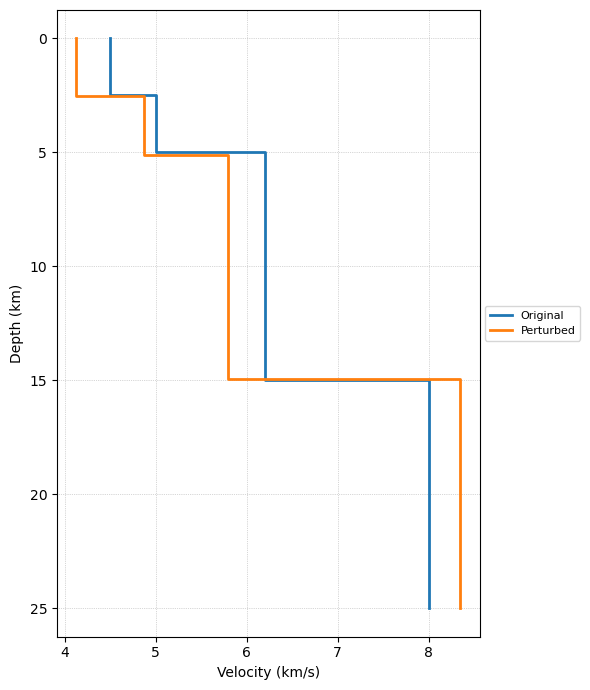

In [9]:
plot_velocity_models(
    [velocity_model, velocity_model_per],
    labels=["Original", "Perturbed"]
)

In [10]:
%%time
location_result = single.SINGLE(
    stations,
    pick_dict,
    velocity_model, 
    ZTR = 15,
    max_num_iterations=100,
    origin=(start_lon, start_lat, origin_time),
     use_fortran_speedups=False,
    verbose= False)

CPU times: user 11 ms, sys: 1.26 ms, total: 12.3 ms
Wall time: 14.7 ms


In [11]:
#location_result

In [12]:
# Accessing individual elements
loc_lon = location_result[0]
loc_lat = location_result[1]
loc_depth = location_result[2]
ORG = location_result[3]
SE = location_result[4]
station_phases= location_result[5]
QSD = location_result[6]
NI = location_result[7]
RMS = location_result[-1]

In [13]:
print(RMS, NI, loc_depth, ORG)

0.00673632442180336 5 9.920340729877353 2024-12-31T23:59:59.981328Z


In [14]:
#0.00673632442180336 5 9.920340729877353 2024-12-31T23:59:59.981328Z


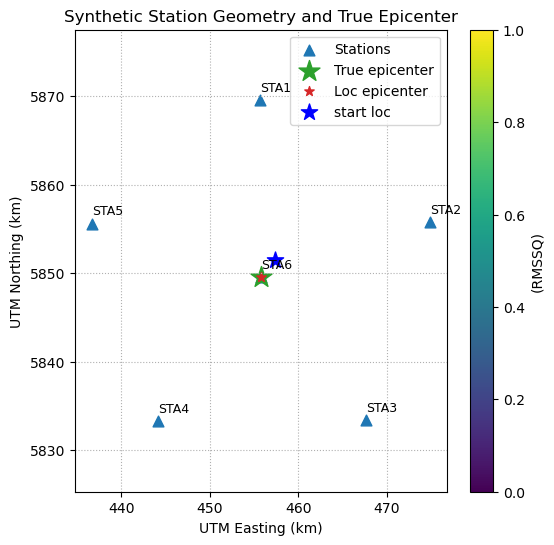

In [15]:

# --- Convert epicenter and stations to UTM (in km) ---
station_lons = [s.lon for s in stations]
station_lats = [s.lat for s in stations]
stat_x, stat_y = lonlat_to_utm(station_lons, station_lats, utm_spec=utm_spec)
stat_x = np.array(stat_x) / 1000.0
stat_y = np.array(stat_y) / 1000.0

eq_x, eq_y = lonlat_to_utm([true_lon], [true_lat], utm_spec=utm_spec)
eq_x, eq_y = eq_x[0] / 1000.0, eq_y[0] / 1000.0

# --- Plot geometry ---
plt.figure(figsize=(6, 6))
plt.scatter(stat_x, stat_y, c='tab:blue', s=60, marker = '^', label='Stations')

plt.scatter(eq_x, eq_y, c='tab:green', marker='*', s=250, label='True epicenter')

loc_x, loc_y = lonlat_to_utm(loc_lon, loc_lat, utm_spec=utm_spec)
loc_x, loc_y = loc_x/1000.0, loc_y/1000.0
plt.scatter(loc_x, loc_y, c='tab:red', marker='*', s=50, label='Loc epicenter')


start_x, start_y = lonlat_to_utm(start_lon, start_lat, utm_spec=utm_spec)
start_x, start_y = start_x/1000.0, start_y/1000.0
plt.scatter(start_x, start_y, c='blue', marker='*', s=150, label='start loc')

for i, s in enumerate(stations):
    plt.text(stat_x[i] + 0.04, stat_y[i] + 1, s.code, fontsize=9)

#plt.scatter(xs, ys, c=fvals,
#            cmap='viridis', s=10, alpha=0.8)

plt.colorbar(label="(RMSSQ)")

plt.xlabel("UTM Easting (km)")
plt.ylabel("UTM Northing (km)")
plt.title("Synthetic Station Geometry and True Epicenter")
plt.axis('equal')
plt.grid(True, ls=':')
plt.legend()
plt.show()

In [16]:
#stations
loc_x - eq_x

0.00032662342795219956

In [17]:
%%time
depths = np.linspace(0, 15, 41)  # 0, 0.5, 1.0, …, 10 km
rms_values = []

for d in depths:
    location_result_ = single.SINGLE(
        stations,
        pick_dict,
        velocity_model, 
        ZTR = d, 
        origin=None,
        #origin=(start_lon, start_lat, origin_time),
        fix_depth= True, 
        use_fortran_speedups=False,
        verbose= False);
    
    rms = location_result_[-1]
    rms_values.append(rms)
    #print(f"Depth = {d:.1f} km → RMS = {rms:.4f}")



CPU times: user 411 ms, sys: 24.2 ms, total: 435 ms
Wall time: 413 ms


In [18]:
#rms_values

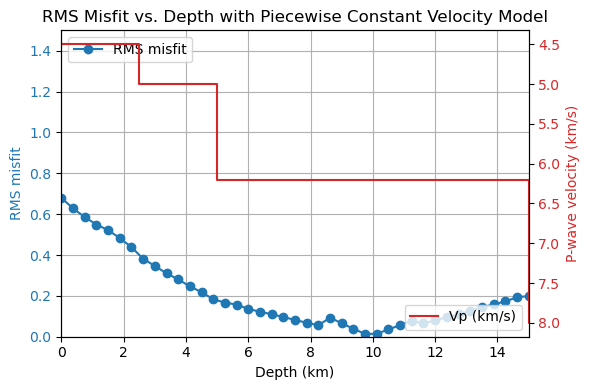

In [19]:
# Extract layer tops/bottoms and velocities
depth_model = np.asarray(velocity_model.depths)  # e.g. [0, 1, 2, 4, 8, 20]
vp_model = np.asarray(velocity_model.VP)         # e.g. [5.0, 5.5, 6.0, 6.7, 7.8]

# Ensure same number of interfaces
if len(vp_model) == len(depth_model) - 1:
    # Standard case: velocities correspond to layers between boundaries
    depth_steps = np.repeat(depth_model, 2)[1:-1]
    vp_steps = np.repeat(vp_model, 2)
else:
    # If same length, assume each depth has a defined vp (continuous)
    depth_steps = np.repeat(depth_model, 2)[1:-1]
    vp_steps = np.repeat(vp_model, 2)[0:len(depth_steps)]

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(6, 4))

# RMS misfit curve
ax1.plot(depths, rms_values, marker='o', color='tab:blue', label='RMS misfit')
ax1.set_xlabel("Depth (km)")
ax1.set_ylabel("RMS misfit", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)
ax1.set_xlim(0, 15)
ax1.set_ylim(0,1.5)

# Velocity model (piecewise constant)
ax2 = ax1.twinx()
ax2.step(depth_steps, vp_steps, where='post', color='tab:red', label='Vp (km/s)')
ax2.invert_yaxis()
ax2.set_ylabel("P-wave velocity (km/s)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Combine legends and title
ax1.legend(loc='upper left')
ax2.legend(loc='lower right')
plt.title("RMS Misfit vs. Depth with Piecewise Constant Velocity Model")
fig.tight_layout()
plt.show()

In [20]:
(loc_lon , loc_lat, ORG)

(146.5000037399368, -37.49999329284244, 2024-12-31T23:59:59.981328Z)

## S-P Location - WIP

In [21]:
#promote_to_sp_pairs(pick_dict)

In [22]:
%%time
location_result_smp = single.SINGLE(
    stations,
    pick_dict,
    velocity_model, 
    ZTR = 5,
    max_num_iterations=100,
    origin=(start_lon, start_lat, origin_time),
    use_s_minus_p=True, # ← NEW ARGUMENT (dansand)
    use_s_picks=False,
     use_fortran_speedups=False,
    verbose= False)

CPU times: user 9.07 ms, sys: 1.22 ms, total: 10.3 ms
Wall time: 9.39 ms


In [23]:
# Accessing individual elements
loc_lon_smp = location_result_smp[0]
loc_lat_smp  = location_result_smp[1]
loc_depth_smp  = location_result_smp[2]
ORG_smp  = location_result_smp[3]

In [24]:
#Simple test that solution is same as original
print(loc_lon - loc_lon_smp), print(loc_depth - loc_depth_smp)

-2.202802011197491e-05
0.14946830086410046


(None, None)

In [25]:
loc_depth_smp 

9.770872429013252

In [26]:
from copy import deepcopy

In [27]:
def jitter_picks(pick_dict_in, sigma_clock=0.02, rng=None):
    """
    Apply a single Gaussian clock drift (seconds) per station.
    Both P and S picks at that station are shifted by the same amount.

    Parameters
    ----------
    pick_dict_in : dict
        Original pick dictionary {station: {'P': PhasePick, 'S': PhasePick}}
    sigma_clock : float
        Standard deviation of the station clock drift (seconds)
    rng : np.random.Generator, optional
        Random generator (for reproducibility)

    Returns
    -------
    dict
        Deep-copied and time-shifted pick_dict
    """
    if rng is None:
        rng = np.random.default_rng()
    pd = deepcopy(pick_dict_in)

    for sta, phases in pd.items():
        drift = float(rng.normal(0.0, sigma_clock))  # one offset per station
        for phase in ("P", "S"):
            if phase in phases and phases[phase] is not None:
                phases[phase].datetime += drift

    return pd

In [28]:
pick_dict_perturb= jitter_picks(pick_dict, sigma_clock=45, rng=np.random.default_rng())

In [29]:
print("Station | ΔP (s) | ΔS (s) | Δ(S–P) (s) ) | (S–P) (s)") 
print("---------------------------------------")
for sta in pick_dict:
    p0 = pick_dict[sta]["P"].datetime
    s0 = pick_dict[sta]["S"].datetime
    p1 = pick_dict_perturb[sta]["P"].datetime
    s1 = pick_dict_perturb[sta]["S"].datetime

    dP = p1 - p0
    dS = s1 - s0
    dSP = (s1 - p1) - (s0 - p0)
    SmP = (s1 - p1)

    print(f"{sta:6s} | {dP:+6.3f} | {dS:+6.3f} | {dSP:+7.4f}) | {SmP:+7.4f}")

Station | ΔP (s) | ΔS (s) | Δ(S–P) (s) ) | (S–P) (s)
---------------------------------------
STA1   | -76.083 | -76.083 | +0.0000) | +2.9482
STA2   | +35.959 | +35.959 | +0.0000) | +2.9575
STA3   | +128.032 | +128.032 | +0.0000) | +2.9508
STA4   | +40.708 | +40.708 | +0.0000) | +2.9508
STA5   | -20.644 | -20.644 | +0.0000) | +2.9576
STA6   | +42.131 | +42.131 | +0.0000) | +1.3593


In [30]:
location_result_smp_perturb = single.SINGLE(
    stations,
    pick_dict,
    velocity_model, 
    ZTR = 5,
    max_num_iterations=100,
    origin=(start_lon, start_lat, origin_time),
    use_s_minus_p=True,
     use_fortran_speedups=False,
    verbose= False)

In [31]:
# Accessing individual elements
loc_lon_smp_perturb = location_result_smp_perturb[0]
loc_lat_smp_perturb  = location_result_smp_perturb[1]
loc_depth_smp_perturb  = location_result_smp_perturb[2]
ORG_smp_perturb  = location_result_smp_perturb[3]

In [32]:
loc_lon_smp_perturb - loc_lon, loc_lat_smp_perturb - loc_lat, loc_depth_smp_perturb - loc_depth

(2.202802011197491e-05, 8.172124744021403e-06, -0.14946830086410046)

In [33]:
loc_depth_smp_perturb, loc_depth

(9.770872429013252, 9.920340729877353)

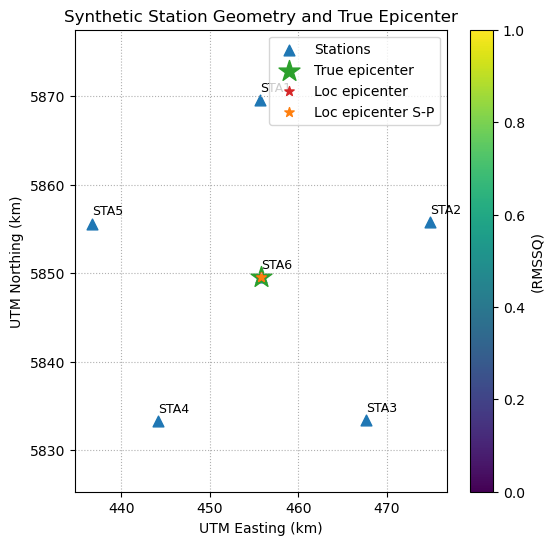

In [34]:
# --- Convert epicenter and stations to UTM (in km) ---
station_lons = [s.lon for s in stations]
station_lats = [s.lat for s in stations]
stat_x, stat_y = lonlat_to_utm(station_lons, station_lats, utm_spec=utm_spec)
stat_x = np.array(stat_x) / 1000.0
stat_y = np.array(stat_y) / 1000.0

eq_x, eq_y = lonlat_to_utm([true_lon], [true_lat], utm_spec=utm_spec)
eq_x, eq_y = eq_x[0] / 1000.0, eq_y[0] / 1000.0

# --- Plot geometry ---
plt.figure(figsize=(6, 6))
plt.scatter(stat_x, stat_y, c='tab:blue', s=60, marker = '^', label='Stations')

plt.scatter(eq_x, eq_y, c='tab:green', marker='*', s=250, label='True epicenter')

loc_x, loc_y = lonlat_to_utm(loc_lon, loc_lat, utm_spec=utm_spec)
loc_x, loc_y = loc_x/1000.0, loc_y/1000.0
plt.scatter(loc_x, loc_y, c='tab:red', marker='*', s=50, label='Loc epicenter')

loc_x_smp_perturb, loc_y_smp_perturb = lonlat_to_utm(loc_lon_smp_perturb, loc_lat_smp_perturb, utm_spec=utm_spec)
loc_x_smp_perturb, loc_y_smp_perturb = loc_x_smp_perturb/1000.0, loc_y_smp_perturb/1000.0
plt.scatter(loc_x_smp_perturb, loc_y_smp_perturb, c='tab:orange', marker='*', s=50, label='Loc epicenter S-P')


for i, s in enumerate(stations):
    plt.text(stat_x[i] + 0.04, stat_y[i] + 1, s.code, fontsize=9)

#plt.scatter(xs, ys, c=fvals,
#            cmap='viridis', s=10, alpha=0.8)

plt.colorbar(label="(RMSSQ)")

plt.xlabel("UTM Easting (km)")
plt.ylabel("UTM Northing (km)")
plt.title("Synthetic Station Geometry and True Epicenter")
plt.axis('equal')
plt.grid(True, ls=':')
plt.legend()
plt.show()

## Real events 

- aftershocks of 2023 $M_L$ 5.0 event near Apollo Bay, Victoria

In [35]:
from obspy import read_events, UTCDateTime
import glob
from obspy import read_inventory

In [36]:
# --- Directory containing your StationXML files ---
station_dir = "./data/apollo_bay_metadata/"   # e.g., "data/stations"
station_files = glob.glob(f"{station_dir}/*.xml")

stations = []
for f in station_files:
    inv = read_inventory(f)
    for net in inv:
        for sta in net:
            lon = sta.longitude
            lat = sta.latitude
            elev = sta.elevation / 1000.0  # m → km
            code = f"{net.code}.{sta.code}"
            stations.append(Station(code, lon, lat, elev))

print(f"✅ Loaded {len(stations)} stations from {station_dir}")

✅ Loaded 8 stations from ./data/apollo_bay_metadata/


In [37]:
#Station

In [38]:
# --- Read the initial catalog ---

# contains events deteceted and automatically located by Seisbench/PyOcto
cat = read_events("./data/seisbench_cat.xml")

In [39]:
%%time

station_index = {s.code.split('.')[-1]: s for s in stations}

relocated_events = []
for i, ev in enumerate(cat, 1):
    origin_info, pick_dict, picked_stations = build_pick_dict_from_event(ev)

    lat0 = origin_info["latitude"]
    lon0 = origin_info["longitude"]
    depth0 = origin_info["depth_km"]
    origin_time = origin_info["time"]

    # pick_dict has keys like "STA1", "STA2", etc.
    picked_station_codes = set(pick_dict.keys())


    # pick_dict has keys like "STA1", "STA2", etc.
    picked_station_codes = set(pick_dict.keys())
    # Filter your master station list to include only those with matching codes
    stations_subset = [s for s in stations if s.code.split('.')[-1] in picked_station_codes]
    # Optional: sanity check
    missing = picked_station_codes - {s.code.split('.')[-1] for s in stations_subset}
    if missing:
        print(f"⚠️ Missing station metadata for: {', '.join(missing)}")


    # --- Run location ---
    location_result = single.SINGLE(
        stations_subset,
        pick_dict,
        velocity_model, 
        ZTR = depth0, 
        origin=(lon0 , lat0 , origin_time),
        use_fortran_speedups=False,
        verbose= False)

    # Accessing individual elements
    loc_lon = location_result[0]
    loc_lat = location_result[1]
    loc_depth = location_result[2]
    ORG = location_result[3]
    SE = location_result[4]
    station_phases= location_result[5]
    QSD = location_result[6]
    rms = location_result[-1]

    # --- Collect results ---
    relocated_events.append({
        "event_id": ev.resource_id.id,
        "original_lat": lat0,
        "original_lon": lon0,
        "original_depth_km": depth0,
        "relocated_lat": loc_lat,
        "relocated_lon": loc_lon,
        "relocated_depth_km": loc_depth,
        "rms": rms,
        "datetime": ORG,
    })



CPU times: user 731 ms, sys: 11.1 ms, total: 742 ms
Wall time: 733 ms


In [40]:
(lon0 , lat0 , origin_time)

(143.2997887981247, -38.70540720806458, 2023-12-26T15:16:57.855122Z)

In [41]:
# Build DataFrame
df = pd.DataFrame(relocated_events)

# Convert datetime safely (ObsPy UTCDateTime → pandas Timestamp)
df["datetime"] = pd.to_datetime(df["datetime"].astype(str), errors="coerce")


In [42]:
df.columns

Index(['event_id', 'original_lat', 'original_lon', 'original_depth_km',
       'relocated_lat', 'relocated_lon', 'relocated_depth_km', 'rms',
       'datetime'],
      dtype='object')

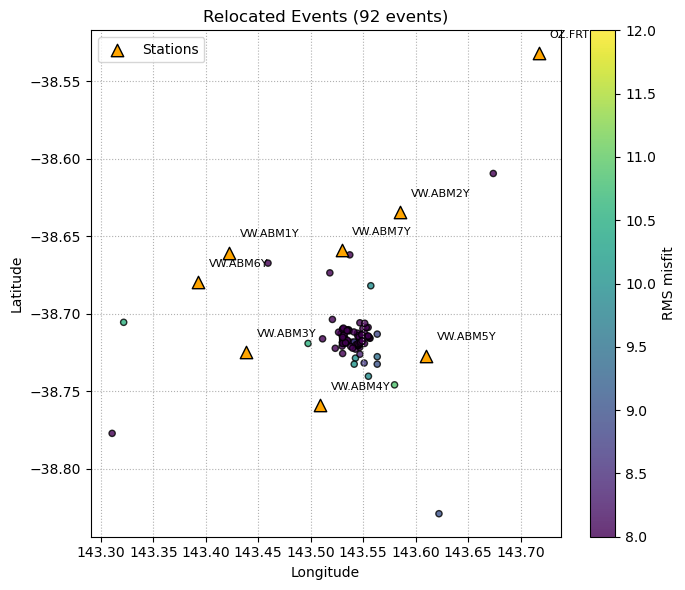

In [43]:

# Basic QC plot for relocated events
plt.figure(figsize=(7,6))
sc = plt.scatter(
    df["relocated_lon"], df["relocated_lat"],
    c=df["relocated_depth_km"] if "rms" in df.columns else "tab:red",
    cmap="viridis", s=20, edgecolor="k", alpha=0.8, vmin=8, vmax=12)
plt.colorbar(sc, label="RMS misfit")

# Overlay stations (optional)
if "stations" in locals():
    st_lons = [s.lon for s in stations]
    st_lats = [s.lat for s in stations]
    plt.scatter(st_lons, st_lats, marker="^", s=80, color="orange", edgecolor="k", label="Stations")
    for s in stations:
        plt.text(s.lon + 0.01, s.lat + 0.01, s.code, fontsize=8)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Relocated Events ({len(df)} events)")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

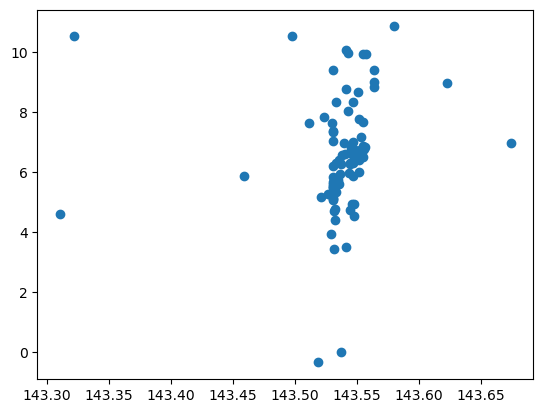

In [44]:
plt.scatter(df["relocated_lon"], df["relocated_depth_km"])

In [45]:
from hypo71py.interface.obspy import load_stations_from_stationxml

stations = load_stations_from_stationxml("./data/apollo_bay_metadata")
print(len(stations), stations[0])

8 <hypo71py.model.station_phase.Station object at 0x144cb0dc0>


In [46]:
from obspy import read_events

cat = read_events("./data/seisbench_cat.xml")
ev = cat[0]

print(ev)
print(ev.origins)
print(ev.picks[:3])

Event:	2023-10-24T04:58:44.924359Z | -38.732, +143.530 | 99.0  ML | automatic

	 resource_id: ResourceIdentifier(id="smi:local/753663f3-2f91-4385-b2c9-3f05dfa5cbc4")
	        ---------
	       picks: 7 Elements
	     origins: 1 Elements
	  magnitudes: 1 Elements
[Origin(resource_id=ResourceIdentifier(id="smi:local/ee506ac7-88a0-48c9-aa3e-767aa7a41532"), time=UTCDateTime(2023, 10, 24, 4, 58, 44, 924359), longitude=143.5303831547119, latitude=-38.732389548058705, depth=9765.625, depth_type='from location', quality=OriginQuality(used_phase_count=7), evaluation_mode='automatic', evaluation_status='preliminary')]
[Pick(resource_id=ResourceIdentifier(id="smi:local/7ef2f2cf-dc15-4e4c-b405-7e2197b38c91"), time=UTCDateTime(2023, 10, 24, 4, 58, 47, 498667), waveform_id=WaveformStreamID(network_code='VW', station_code='ABM1Y', channel_code='P', location_code='00'), phase_hint='P', evaluation_mode='automatic', evaluation_status='preliminary'), Pick(resource_id=ResourceIdentifier(id="smi:local/dc77

In [47]:
from hypo71py.interface.obspy import relocate_event_obspy

In [48]:


ev_out, new_origin = relocate_event_obspy(
    ev,
    stations,
    velocity_model,
    make_preferred=True,
    verbose=False,
)

In [49]:
new_origin

Origin
	   resource_id: ResourceIdentifier(id="smi:local/c1240c32-2856-4006-b7d5-1e6d3fe9f527")
	          time: UTCDateTime(2023, 10, 24, 4, 58, 44, 955203)
	     longitude: 143.52334645189939
	      latitude: -38.72216577143587
	         depth: 7842.583179473877
	       quality: OriginQuality(associated_phase_count=7, used_phase_count=7, used_station_count=4, standard_error=0.11436011144528892)
	 creation_info: CreationInfo(agency_id='hypo71py')

In [50]:
from hypo71py.interface.obspy import relocate_catalog_obspy

cat_reloc, summary, failures = relocate_catalog_obspy(
    cat,
    stations,
    velocity_model,
    make_preferred=True,
    verbose=False,
    in_place=False,          # keeps original catalog intact
    stop_on_error=False,     # keep going even if some events fail
)

print("Relocated:", len(summary))
print("Failed:", len(failures))

Relocated: 92
Failed: 0


## Convert to a dataframe using Obsplus

In [52]:
import obsplus

In [53]:

ev_df = obsplus.events_to_df(cat_reloc)

In [55]:
ev_df.head(5)

,time,latitude,longitude,depth,magnitude,event_description,associated_phase_count,azimuthal_gap,event_id,horizontal_uncertainty,...,standard_error,used_phase_count,station_count,vertical_uncertainty,updated,author,agency_id,creation_time,version,stations
0,2023-10-24 04:58:44.955056640,-38.722166,143.523346,7842.583179,99.0,,7.0,NaN,smi:local/753663f3-2f91-4385-b2c9-3f05dfa5cbc4,NaN,...,0.114271,7.0,0.0,NaN,1970-01-01,,,NaT,,
1,2023-10-24 08:39:54.539140352,-38.716724,143.532638,5347.858548,99.0,,7.0,NaN,smi:local/675f327d-62f1-4407-b718-7462fa871786,NaN,...,0.023178,7.0,0.0,NaN,1970-01-01,,,NaT,,
2,2023-10-24 12:03:46.509257984,-38.709748,143.530388,5273.419619,99.0,,9.0,NaN,smi:local/f9920ab4-fc2c-41fb-a9f8-c58630058dbd,NaN,...,0.169078,9.0,0.0,NaN,1970-01-01,,,NaT,,
3,2023-10-24 13:16:04.272120832,-38.714395,143.553635,6661.711901,99.0,,8.0,NaN,smi:local/ab66bd56-0c3d-4d44-a18e-8c3e4e440a9a,NaN,...,0.020730,8.0,0.0,NaN,1970-01-01,,,NaT,,
4,2023-10-24 16:52:53.596186112,-38.710178,143.536011,5951.431572,99.0,,8.0,NaN,smi:local/ac8a9701-c5bc-4db9-a71b-93cb86db3d15,NaN,...,0.037944,8.0,0.0,NaN,1970-01-01,,,NaT,,
